# **Шаг 1**: Предобработка изображений c использованием библиотеки Computer vision

Загрузим стандартные библиотеки для работы с данными и визуализации:

In [1]:
import numpy as np                  
import pandas as pd
import matplotlib.pyplot as plt

import os
import glob

from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import json

import cv2

try:
    import pylibjpeg
except:
    !pip install /kaggle/input/rsna-packages/{pydicom-2.3.0-py3-none-any.whl,pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}
#! pip install -U pylibjpeg pylibjpeg-openjpeg pylibjpeg-libjpeg pydicom python-gdcm
#! pip install --upgrade pydicom 

import pydicom

Processing /kaggle/input/rsna-packages/pydicom-2.3.0-py3-none-any.whl
Processing /kaggle/input/rsna-packages/pylibjpeg-1.4.0-py3-none-any.whl
Processing /kaggle/input/rsna-packages/python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
  Attempting uninstall: pydicom
    Found existing installation: pydicom 2.3.1
    Uninstalling pydicom-2.3.1:
      Successfully uninstalled pydicom-2.3.1


In [2]:
df_train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
df_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [3]:
df_train['age']= df_train['age'].\
fillna(df_train.groupby('cancer')['age'].transform('mean'))
df_train['age'].isna().sum()

0

In [4]:
## VV: добавим в датасет пути к файлам
IMG_PATH = '/kaggle/input/rsna-breast-cancer-detection/train_images/'
df_train['image_path'] =  IMG_PATH + df_train.patient_id.map(str) + \
'/' + df_train.image_id.map(str) + '.dcm'

df_train.iloc[0]['image_path']

'/kaggle/input/rsna-breast-cancer-detection/train_images/10006/462822612.dcm'

Определим функцию предобработки изображений через cv2 и проверим ее работу.

На Kaggle есть несколько ноутбуков для предобработки маммографических изображений. Один из них мы будем использовать. Он (1) сводит фотометрические интерпретации к одному виду, (2) выбирает информативные регионы, (3) приводит все изображения к одной размерности.

In [5]:
## VV: адаптировано из блокнота https://www.kaggle.com/code/fabiendaniel/dicom-cropped-resized-png-jpg
def crop_image(path, show=True, width=224, height=224, resize = True, gabor = False): ## определим функцию
    dicom = pydicom.dcmread(path)               ## прочитаем dicom            
    later = dicom.ImageLaterality               ## правая или левая грудь
    img = dicom.pixel_array                     ## прочитаем само изображение
    if img.max() - img.min() != 0:
        img = (img - img.min()) / (img.max() - img.min()) ## проведем нормализацию   
    img *= 255                                  ## от диапазона 0-1 перейдем к 0-255
    img = np.uint8(img)

    if dicom.PhotometricInterpretation == "MONOCHROME1":
        img = 1 - img ## VV: приведение к одному виду фотометрической интерпретации

    bin_pixels = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)[1] ## проведем бинаризацию
   
    # определим контуры на изображении
    contours, _ = cv2.findContours(bin_pixels.astype(np.uint8), \
                                   cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = max(contours, key=cv2.contourArea)

    # Create a mask from the largest contour
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
   
    # Use bitwise_and to get masked part of the original image
    out = cv2.bitwise_and(img,mask)
    
    # get bounding box of contour
    y1, y2 = np.min(contour[:, :, 1]), np.max(contour[:, :, 1])
    x1, x2 = np.min(contour[:, :, 0]), np.max(contour[:, :, 0])
    
    x1 = int(0.99 * x1)
    x2 = int(1.01 * x2)
    y1 = int(0.99 * y1)
    y2 = int(1.01 * y2)
    cropped = out[y1:y2, x1:x2]
    
    if gabor:
        ksize = 35  # The local area to evaluate
        sigma = 3.0  # Larger Values produce more edges
        lambd = 10.0
        gamma = 0.5
        psi = 0 
        theta = 0.57 ## check EDA for details
        kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
    
    ## VV: let's resize
    dim = (width, height)
    resized = cv2.resize(cropped, dim,interpolation = cv2.INTER_AREA)
    if later == 'R':
        resized = cv2.flip(resized, 1) ## приведем все к одной латеральности
    if show:
        if resize:
            plt.imshow(resized, cmap="turbo") 
        else:
            plt.imshow(cropped, cmap="turbo")
    if resize:
        return resized ## изменим размер
    else:
        return cropped ## или просто остановимся на вырезанном фрагменте

Посмотрим, как выглядит результат работы функции:

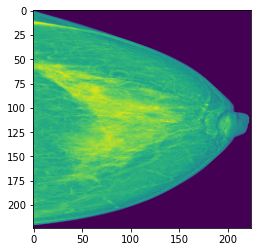

In [6]:
img_index = 0
img_file = pydicom.dcmread(df_train['image_path'].iloc[img_index])
img = img_file.pixel_array
img_crop = crop_image(df_train['image_path'].iloc[img_index])

plt.imshow(img_crop)

In [7]:
import os

DATASET_NAME = f'RSNA-cropped-png-train'
SAVE_FOLDER = f"/kaggle/working/{DATASET_NAME}"
EXTENSION = "png"
os.makedirs(SAVE_FOLDER, exist_ok=True)

DEBUG_MODE = False

In [8]:
import random
random.seed(10)
#
n_cases = df_train[df_train.cancer == 1].image_id.count()
## выберем онко случаи
df_train_canc = df_train[df_train.cancer == 1]
## выберем здоровые случаи в количестве равном онко
df_train_healthy = df_train[(df_train.cancer == 0) & (df_train.implant == 0)]
df_train_healthy = df_train_healthy.\
iloc[random.sample(range(0, len(df_train_healthy) - 1), n_cases)]
## добавим пациенток с имплантами
df_train_implant = df_train[df_train.implant == 1]

df_train_cut = pd.concat([df_train_canc,
                          df_train_healthy,
                         df_train_implant], ignore_index = True)
print(df_train_cut.shape)

## Временный датасет для отладки
df_train_cut_cut = df_train_cut.iloc[random.sample(range(0, len(df_train_cut) - 1), 100)]
df_train_cut_cut.head()

if DEBUG_MODE:
    df_proc = df_train_cut_cut
else:
    df_proc = df_train_cut

(3793, 15)


In [9]:
def process(f,save_folder="", extension="png"):
    patient = f.split('/')[-2]
    image = f.split('/')[-1][:-4]
    img = crop_image(f)
    cv2.imwrite(f"{SAVE_FOLDER}/{patient}_{image}.{extension}", img)

In [10]:
## VV: cuda https://thedatafrog.com/en/articles/boost-python-gpu/

paths = df_proc['image_path'] #df_train_cut_cut - для отладки
_ = Parallel(n_jobs=8)(
    delayed(process)(uid, save_folder=SAVE_FOLDER, extension=EXTENSION)
    for uid in tqdm(paths)
)

  0%|          | 0/3793 [00:00<?, ?it/s]

In [11]:
os.makedirs(SAVE_FOLDER +'_gabor', exist_ok=True)

def process2(f,save_folder="", extension="png"):
    patient = f.split('/')[-2]
    image = f.split('/')[-1][:-4]
    img = crop_image(f, gabor=True)
    cv2.imwrite(f"{SAVE_FOLDER}_gabor/{patient}_{image}.{extension}", img)
    
_ = Parallel(n_jobs=8)(
    delayed(process2)(uid, save_folder=(SAVE_FOLDER +'_gabor'), extension=EXTENSION)
    for uid in tqdm(paths)
)

  0%|          | 0/3793 [00:00<?, ?it/s]

Пропишем путь к обрезанным фигурам в датасет

In [12]:
df_proc['new_image_path'] = SAVE_FOLDER + '/' +\
df_proc.patient_id.map(str) + '_' +\
df_proc.image_id.map(str) + '.' +\
EXTENSION # SAVE_FOLDER
df_proc.to_csv(SAVE_FOLDER + '/' + 'df_train.csv',index=False)
df_proc.to_csv(SAVE_FOLDER +'_gabor' + '/' + 'df_train.csv',index=False)
glob.glob(SAVE_FOLDER + '/*.csv')

['/kaggle/working/RSNA-cropped-png-train/df_train.csv']

Я думаю обойтись частью датасета, чтобы сократить время работы. Так как изначальный датасет несбалансирован, то можно сделать что-то вроде case-control study - выбрать равное количество случаев с онко и без. Думаю,насчет того, стоит ли учитывать импланты отдельно.